# Tutorial 1
In this series of tutorial, we are going to build an SNN capable of classifying MNIST by copying the weights obtained by training the following simple ANN using TensorFlow:

Using GeNN for spike-based machine learning.svg

Clearly, this is far from a state of the art architecture, but it still achieves 97.6% accuracy on MNIST. In this first tutorial we are going to build the basic SNN model, present a single test set image to it and visualize the spiking activitiy of the model.

## Install PyGeNN wheel from Google Drive
Download wheel file

In [1]:
if "google.colab" in str(get_ipython()):
    #import IPython
    #IPython.core.magics.execution.ExecutionMagics.run.func_defaults[2] = lambda a: a
    #%run "../install_collab.ipynb"
    !pip install gdown --upgrade
    !gdown 1V_GzXUDzcFz9QDIpxAD8QNEglcSipssW
    !pip install pygenn-5.0.0-cp310-cp310-linux_x86_64.whl
    %env CUDA_PATH=/usr/local/cuda

Downloading...
From: https://drive.google.com/uc?id=1V_GzXUDzcFz9QDIpxAD8QNEglcSipssW
To: /content/pygenn-5.0.0-cp310-cp310-linux_x86_64.whl
100% 8.29M/8.29M [00:00<00:00, 147MB/s]
Processing ./pygenn-5.0.0-cp310-cp310-linux_x86_64.whl
pygenn is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
env: CUDA_PATH=/usr/local/cuda


## Download pre-trained weights and MNIST test data

In [2]:
!gdown 1cmNL8W0QZZtn3dPHiOQnVjGAYTk6Rhpc
!gdown 131lCXLEH6aTXnBZ9Nh4eJLSy5DQ6LKSF

Downloading...
From: https://drive.google.com/uc?id=1cmNL8W0QZZtn3dPHiOQnVjGAYTk6Rhpc
To: /content/weights_0_1.npy
100% 402k/402k [00:00<00:00, 142MB/s]
Downloading...
From: https://drive.google.com/uc?id=131lCXLEH6aTXnBZ9Nh4eJLSy5DQ6LKSF
To: /content/weights_1_2.npy
100% 5.25k/5.25k [00:00<00:00, 18.8MB/s]


## Install MNIST package

In [3]:
!pip install mnist

## Build model
Import standard modules and required PyGeNN functions and classes

In [12]:
import numpy as np
import mnist
import matplotlib.pyplot as plt
from pygenn import (create_neuron_model, create_current_source_model,
                    init_postsynaptic, init_weight_update, GeNNModel)

Define some simulation parameters

In [5]:
# Simulation timestep of model in ms
TIMESTEP = 1.0

# How many timesteps to present images for
PRESENT_TIMESTEPS = 100

# How much to scale input images
INPUT_CURRENT_SCALE = 1.0 / 100.0

Because the ReLU neurons our ANN was trained with are best matched by a very simple Integrate-and-Fire neuron without a leak, define a custom model with:
*   A single parameter (parameters are common across all neurons in population) `Vthr` which specifies it's spiking threshold
*   A single `V` state variable to hold the membrane potential of the neurons
*   Simulation code which simply adds the incoming current `Isyn` (this is a built in variable provided by GeNN) to the membrane potential `V` (note, we're assuming that the membrane resistance is 1 here)
*   Threshold condition code which causes the neuron to emit a spike if it's membrane potential `V` crosses the threshold `Vthr`
*   Reset code which zeros the membrane potential `V` after a spike is emitted.

In [6]:
if_model = create_neuron_model(
    "if_model",
    params=["Vthr"],
    vars=[("V", "scalar")],
    sim_code="V += Isyn;",
    threshold_condition_code="V >= Vthr",
    reset_code="""
    V = 0.0;
    """)

We are going to convert MNIST digits to spikes by simply treating the intensity of each pixel (multiplied by a scaling factor) as a current and injecting it into the neurons in the input population throughout the stimulus presentation time.

To do this we use a very simple custom current source model with:

*   A single `magnitude` state variable to store the per-neuron current to inject
*   Injection code which injects a current of `magnitude` every timestep (`$(injectCurrent, X)` is a function provided by GeNN for use in current sources).



In [7]:
cs_model = create_current_source_model(
    "cs_model",
    vars=[("magnitude", "scalar")],
    injection_code="injectCurrent(magnitude);")

Create a new model implementing `scalar` variables as single-precision and generating code into tutorial_1 directory

In [8]:
model = GeNNModel("float", "tutorial_1")
model.dt = TIMESTEP


Load the weight matrices extracted from our original ANN


In [9]:
# Load weights
weights_0_1 = np.load("weights_0_1.npy")
weights_1_2 = np.load("weights_1_2.npy")

Create three populations of Integrate-and-Fire neurons sized to match the shapes of the weight matrices and initialised so their membrane potential's are all initialised to 0mv and their spiking thresholds to 5mv.

In [10]:
if_init = {"V": 0.0}
if_params = {"Vthr": 5.0}
neurons = [model.add_neuron_population("neuron0", weights_0_1.shape[0],
                                       if_model, if_params, if_init),
           model.add_neuron_population("neuron1", weights_0_1.shape[1],
                                       if_model, if_params, if_init),
           model.add_neuron_population("neuron2", weights_1_2.shape[1],
                                       if_model, if_params, if_init)]

Because, in this first tutorial we want to examine the spike emitted by each neuron, turn on spike recording for each population.

In [11]:
for n in neurons:
    n.spike_recording_enabled = True

Add synapse populations to sequentially connect the three populations of neurons. These are all configured identically with:
*   `DENSE` connectivity meaning that they are connected with a basic dense weight matrix(see [documentation](https://genn-team.github.io/genn/documentation/4/html/d5/d39/subsect34.html)).
*   The built in `StaticPulse` **weight update model** which is used for spiking synapses without any sort of learning. This has no parameters and a single state variable `g` representing its synaptic weights which we initialise using our arrays of pre-trained weights.
*   The build in `DeltaCurr` **postsynaptic model** which specified that weighted incoming spikes are added directly to the postsynaptic neuron's membrane potential without any additional shaping occuring. This model has no parameters or state variables.



In [13]:
model.add_synapse_population(
        "synapse_0_1", "DENSE",
        neurons[0], neurons[1],
        init_weight_update("StaticPulse", {}, {"g": weights_0_1.flatten()}),
        init_postsynaptic("DeltaCurr"))
model.add_synapse_population(
        "synapse_1_2", "DENSE",
        neurons[1], neurons[2],
        init_weight_update("StaticPulse", {}, {"g": weights_1_2.flatten()}),
        init_postsynaptic("DeltaCurr"));

Add current source to provide input into the input population of neurons

In [14]:
current_input = model.add_current_source("current_input", cs_model,
                                         neurons[0], {}, {"magnitude": 0.0})


Run code generator to generate simulation code for model and load it into PyGeNN. Allocate a spike recording buffer large enough to store the spikes emitted throughout a single stimuli presentation.

In [15]:
model.build()
model.load(num_recording_timesteps=PRESENT_TIMESTEPS)

## Simulate model
First we load the two numpy arrays containing the images and labels from the MNIST test set and verify that the size of the input images matches that of the first (input) population and that the size of the last (output) population is enough to one-hot encode all of the labels.

In [17]:
testing_images = mnist.test_images()
testing_labels = mnist.test_labels()

testing_images = np.reshape(testing_images, (testing_images.shape[0], -1))
assert testing_images.shape[1] == neurons[0].num_neurons
assert np.max(testing_labels) == (neurons[-1].num_neurons - 1)

PyGeNN uses *memory views* to directly expose the memory used by the simulation to numpy. Copy the first testing image into the memory view of the current source's magnitude variable.

In [18]:
current_input.vars["magnitude"].values = testing_images[0] * INPUT_CURRENT_SCALE

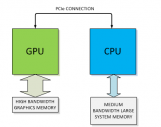

On most systems, memory accessible by the GPU and the CPU is seperate.
Therefore, we need to manually copy the values we just placed in the current source's magnitude variable to the GPU (if we're running GeNN on the CPU, this call will not do anything)

In [19]:
current_input.vars["magnitude"].push_to_device()

Simulate the model for `PRESENT_TIMESTEPS` (`model.timestep` tracks integer timesteps whereas `model.time` tracks time in ms)

In [20]:
while model.timestep < PRESENT_TIMESTEPS:
    model.step_time()

Download the recorded spikes from the GPU

In [21]:
model.pull_recording_buffers_from_device()

Plot raster plots of the spikes from all neuron populations, illustrating the correct label for this image with a horizontal line

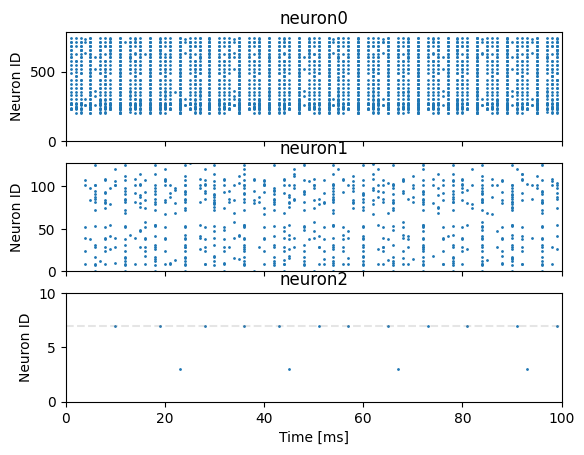

In [23]:
# Create figure with one axis per neuron population
fig, axes = plt.subplots(len(neurons), sharex=True)

# Loop through neuron populations and the axis we're going to plot their raster plot on
for n, a in zip(neurons, axes):
    # Extract spike times and IDs and plot
    spike_times, spike_ids = n.spike_recording_data[0]
    a.scatter(spike_times, spike_ids, s=1)

    a.set_title(n.name)
    a.set_ylabel("Neuron ID")
    a.set_xlim((0, PRESENT_TIMESTEPS * TIMESTEP))
    a.set_ylim((0, n.num_neurons))

# Add an x-axis label and translucent line showing the correct label
axes[-1].set_xlabel("Time [ms]")
axes[-1].hlines(testing_labels[0], xmin=0, xmax=PRESENT_TIMESTEPS,
                linestyle="--", color="gray", alpha=0.2);